In [1]:
# Import packages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from operator import sub
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

C:\Users\310181005\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ARIMA

In [2]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# calculate relative error of two list
def mean_relative_error(predict,actual):
    lst = []
    for i in range(len(actual)):
        mre = abs((predict[i]-actual[i])/actual[i])
        lst.append(mre)
    return sum(lst) / len(lst)  

In [3]:
# Import data
raw = pd.read_csv("raw.csv",usecols=[0,1])
df = raw.copy()

# Check data for null value
print(df.info())

# Summary Statistics
print(df.describe())

# Sort dataframe according to date and keep only one row per date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date']).drop_duplicates(subset=['Date'],keep='last').dropna()

# Find min date and max date
min_date = df['Date'].min()
max_date = df['Date'].max()
print("min date:{}, max date:{}".format(min_date, max_date))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB
None
              Temp
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000
min date:1981-01-01 00:00:00, max date:1990-12-31 00:00:00


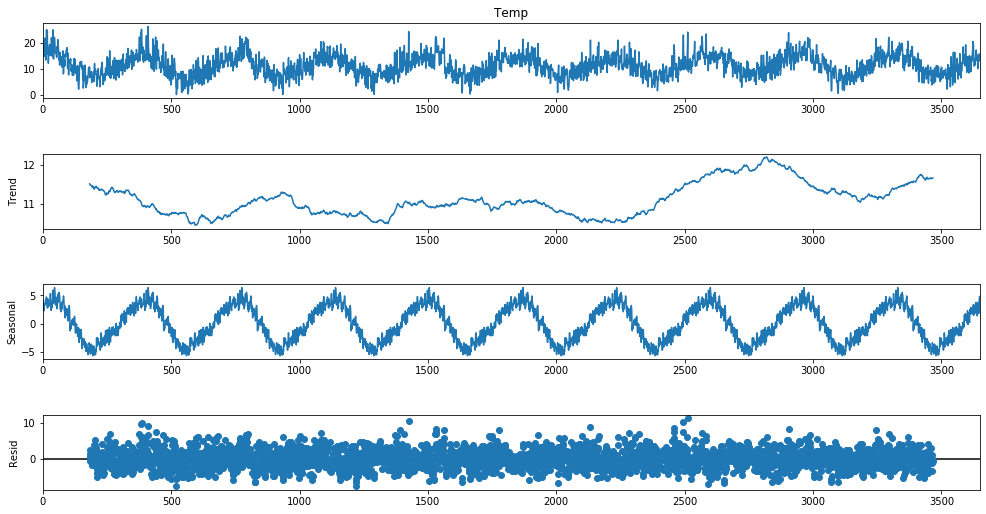

In [4]:
# Decomposing of data
dec = sm.tsa.seasonal_decompose(df['Temp'],freq=365)
fig = dec.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

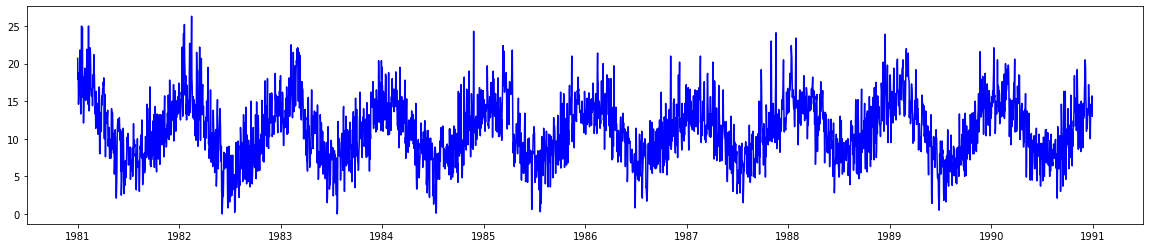

In [5]:
# Line plot
plt.figure(figsize=(20,4))
plt.plot(df['Date'], df['Temp'], 'b') 

In [6]:
# Split data into train and test set
train = df.loc[df['Date'] < '1990-01-01']
test = df.loc[df['Date'] >= '1990-01-01']

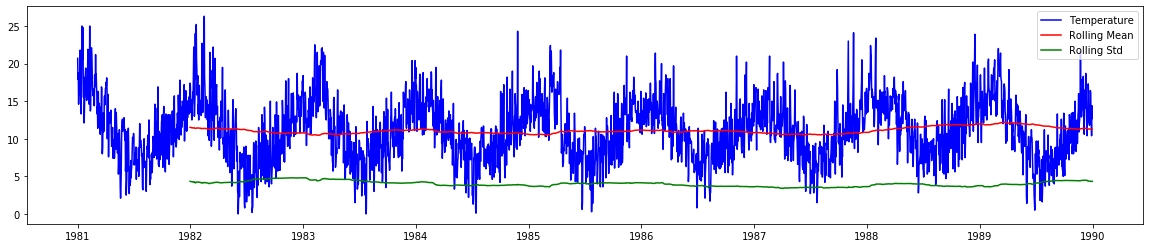

In [7]:
#Determine rolling statistics
rolmean = train.rolling(window=365).mean() 
rolstd = train.rolling(window=365).std()

#Plot rolling statistics
plt.figure(figsize=(20,4))
plt.plot(train['Date'], train['Temp'], 'b', label="Temperature")  
plt.plot(train['Date'], rolmean, 'r', label="Rolling Mean")  
plt.plot(train['Date'], rolstd, 'g', label="Rolling Std") 
plt.legend(loc="upper right")
plt.show()

# As we observe the moving averages, the moving average with window '365' is So, we can confirm that the seasonality(s) is 365.

In [8]:
# check if the series is stationary using the Augmented Dickey Fuller test
# Because, we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.
# The null hypothesis of the ADF test is that the time series is non-stationary. 
# So, if the p-value of the test is less than the significance level (0.05) 
# then we reject the null hypothesis and infer that the time series is indeed stationary.
# So, in our case, if P Value < 0.05 we don't meed to find the order of differencing.

result = adfuller(train.Temp.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


# Double confirm whether we need to do the differencing
## Adf Test
print (ndiffs(train.Temp, test='adf'))

# KPSS test
print (ndiffs(train.Temp, test='kpss'))

# PP test:
print (ndiffs(train.Temp, test='pp'))

ADF Statistic: -4.345532
p-value: 0.000370
0
0
0


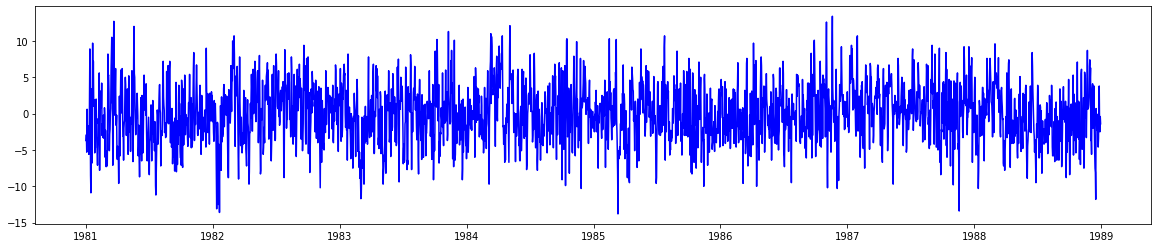

In [9]:
# After performing the stationarity test both the methods return that the time series is stationary. 
# So no preprocessing is required, however still time series differentiation has been performed. 
# The lag value is 365. The reason for this is that the series is daily temperature data (365 days).

# Differencing to remove seasonality
day_in_year = 365
train_differenced = difference(train['Temp'], day_in_year)
train_differ = pd.DataFrame(list(zip(train['Date'].tolist(), train_differenced)), columns =['Date', 'Temp'])

# Line plot after differencing
plt.figure(figsize=(20,4))
plt.plot(train_differ['Date'], train_differ['Temp'], 'b') 

In [10]:
# check if stationary again
result = adfuller(train_differenced)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Note, we are now using the seasonally differenced (train_differenced) as our dataset.

ADF Statistic: -17.836160
p-value: 0.000000


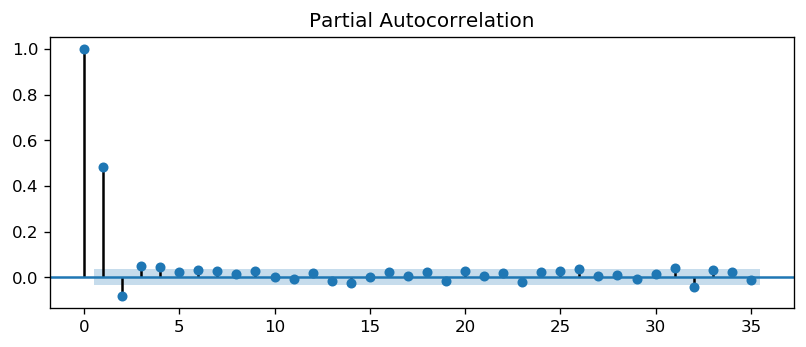

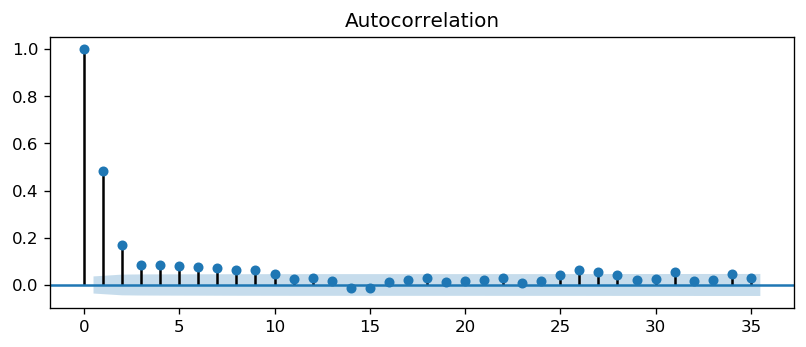

In [11]:
# Find the order of the AR term (p)
plt.rcParams.update({'figure.figsize':(8,3), 'figure.dpi':120})
plot_pacf(train_differenced)

# Find the order of the MA term (q)
plot_acf(train_differenced)
plt.show()

# Below are some observations from the plots.
# The ACF shows first significant lag at 1
# The PACF shows first significant lag at 1
# A good starting point for the p and q values is also 1.
# This quick analysis suggests an ARIMA(1,0,1) on the stationary data may be a good starting point.

In [44]:
# Grid Search ARIMA Hyperparameters Class
class grid_search_arima(object):
    def __init__(self, ori_train_list, train_list, test_list, p_list, d_list, q_list, step, seasonal_day):
        self.ori_train_list = ori_train_list
        self.train_list = train_list
        self.test_list = test_list
        self.p_list = p_list
        self.d_list = d_list
        self.q_list = q_list
        self.step = step
        self.seasonal_day = seasonal_day
        self.model_dict = {}
        
    def run(self):
        history = self.ori_train_list
        for p in self.p_list:
            for d in self.d_list:
                for q in self.q_list:
                    try:
                        model = ARIMA(self.train_list, order=(p, d, q))
                        model_fit = model.fit(disp=0)
                        forecast = model_fit.forecast(steps=self.step)[0]

                        history = self.ori_train_list.copy()
                        predicted = []
                        day = 1

                        for yhat in forecast:
                            inverted = inverse_difference(history, yhat, self.seasonal_day)
                            history.append(inverted)
                            predicted.append(inverted)
                            day += 1

                        model_name = "{},{},{}".format(p,d,q)
                        self.model_dict[model_name] = {'aic':model_fit.aic,
                                                      'bic':model_fit.bic,
                                                      'res':model_fit.resid.tolist(),
                                                      'prediction':predicted,
                                                      'mae':mean_absolute_error(self.test_list, predicted),
                                                      'mre':mean_relative_error(predicted,self.test_list)}
                        print ("({},{},{}) success".format(p,d,q))
                        print(model_fit.summary())

                    except:
                        print ("({},{},{}) failed".format(p,d,q))

                    
                    
                    

In [61]:
# Instantiate a grid_search_arima object
gsa = grid_search_arima(ori_train_list = train['Temp'].tolist(),
                        train_list = train_differenced.tolist(),
                        test_list = test['Temp'].tolist(),
                        p_list = [1,2,3],
                        d_list = [0],
                        q_list = [1,2,3],
                        step = 365, 
                        seasonal_day = day_in_year)
# Run result
gsa.run()

(1,0,1) success
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2920
Model:                     ARMA(1, 1)   Log Likelihood               -7764.636
Method:                       css-mle   S.D. of innovations              3.456
Date:                Mon, 20 Apr 2020   AIC                          15537.273
Time:                        10:43:29   BIC                          15561.190
Sample:                             0   HQIC                         15545.888
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0332      0.115     -0.289      0.772      -0.258       0.192
ar.L1.y        0.3377      0.036      9.469      0.000       0.268       0.408
ma.L1.y        0.1887      0.037    

(3,0,3) failed


In [62]:
# Compare arima model performance
print("{}\t{}\t{}\t{}\t{}".format('p,d,q','aic','bic','mae','mre'))
print("-----------------------------------")
for k in gsa.model_dict.keys():
    print ("{}\t{:.0f}\t{:.0f}\t{:.2f}\t{:.2f}".format(k,gsa.model_dict[k]['aic'],
                                                       gsa.model_dict[k]['bic'],
                                                       gsa.model_dict[k]['mae'],
                                                       gsa.model_dict[k]['mre']))

p,d,q	aic	bic	mae	mre
-----------------------------------
1,0,1	15537	15561	2.87	0.28
1,0,2	15536	15566	2.87	0.28
2,0,1	15539	15569	2.87	0.28
3,0,1	15524	15560	2.87	0.28
3,0,2	15526	15568	2.87	0.28



Residuals - ARIMA(1,0,1)

                 0
count  2920.000000
mean      0.000456
std       3.456833
min     -10.977574
25%      -2.255361
50%       0.011626
75%       2.231518
max      11.193946

Residuals - ARIMA(1,0,2)

                 0
count  2920.000000
mean      0.000878
std       3.454890
min     -10.748489
25%      -2.237493
50%      -0.002130
75%       2.228091
max      11.183989

Residuals - ARIMA(2,0,1)

                 0
count  2920.000000
mean      0.000485
std       3.456568
min     -10.976248
25%      -2.249167
50%       0.017818
75%       2.226289
max      11.198949

Residuals - ARIMA(3,0,1)

                 0
count  2920.000000
mean      0.001494
std       3.446648
min     -10.417489
25%      -2.209650
50%       0.001702
75%       2.177790
max      11.265497

Residuals - ARIMA(3,0,2)

                 0
count  2920.000000
mean      0.001468
std       3.446642
min     -10.404350
25%      -2.205807
50%      -0.000545
75%       2.171517
max      11.266963


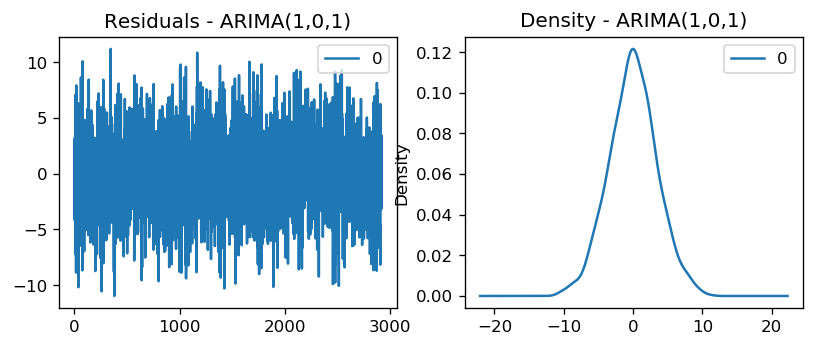

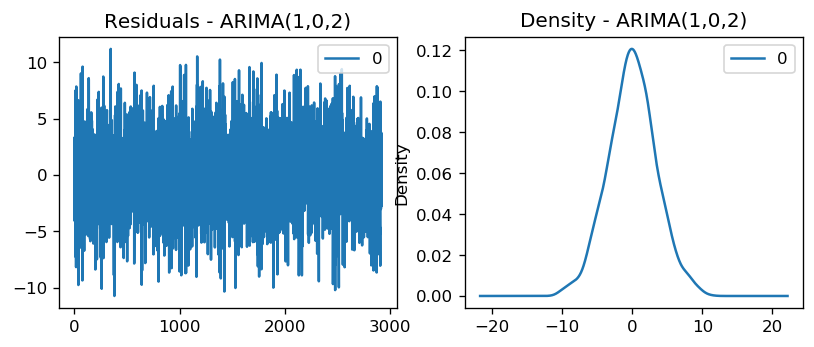

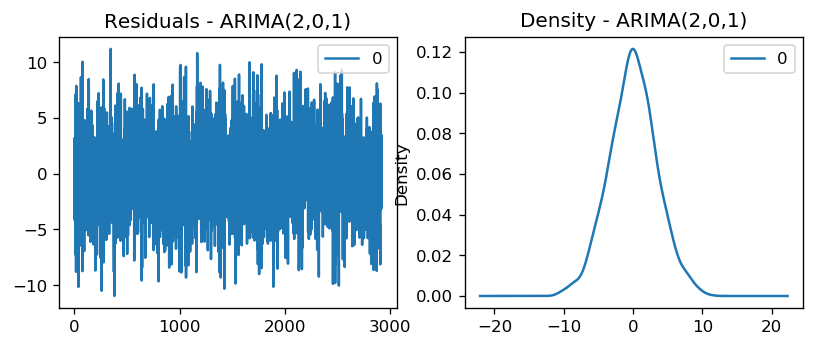

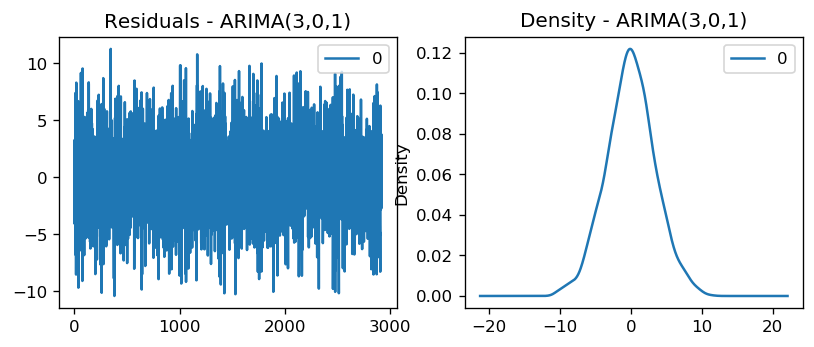

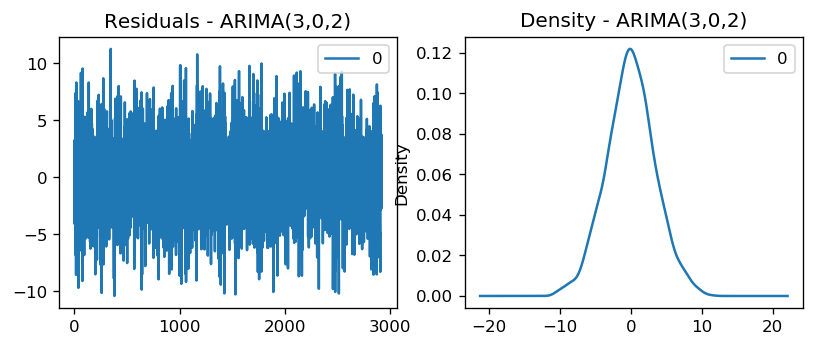

In [72]:
# Print residual errors of all arima model
for k in gsa.model_dict.keys():
    residuals = pd.DataFrame(gsa.model_dict[k]['res'])
    print("\nResiduals - ARIMA({})\n".format(k))
    print(residuals.describe())
    
# Plot residual errors of all arima model
for k in gsa.model_dict.keys():
    residuals = pd.DataFrame(gsa.model_dict[k]['res'])
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals - ARIMA({})".format(k), ax=ax[0])
    residuals.plot(kind='kde', title="Density - ARIMA({})".format(k), ax=ax[1])
    plt.savefig('ARIMA({})_Residuals.png'.format(k))
    plt.show()

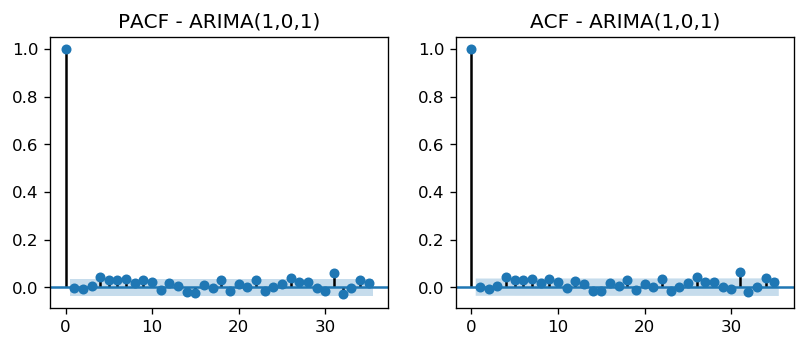

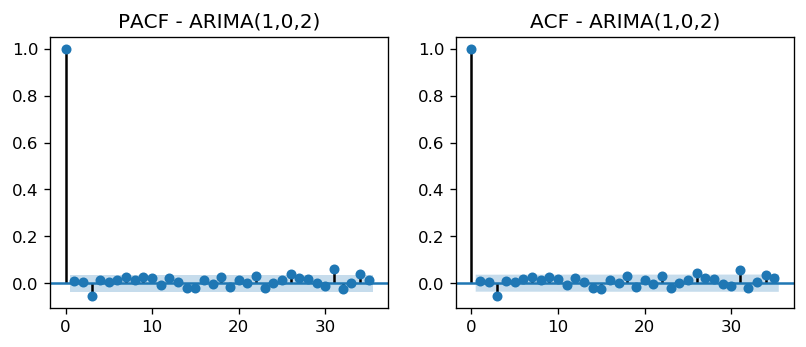

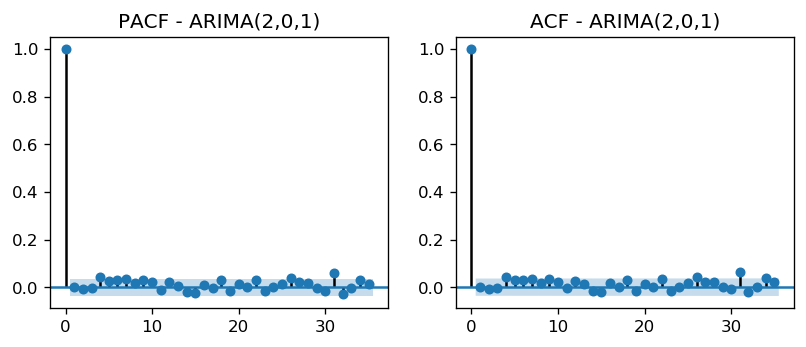

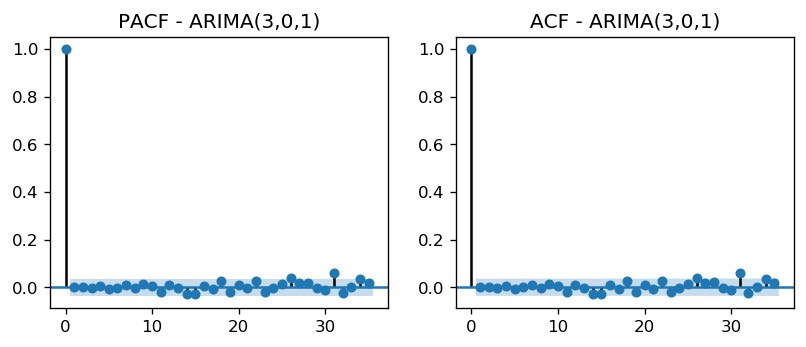

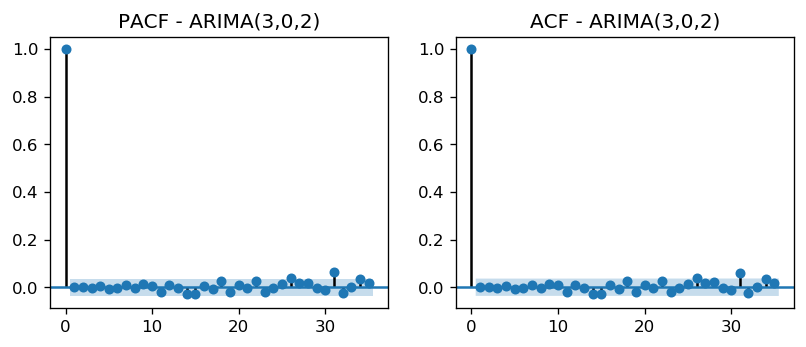

In [68]:
# creates ACF and PACF plots to check for any significant autocorrelation.
for k in gsa.model_dict.keys():
    residuals = pd.DataFrame(gsa.model_dict[k]['res'])
    fig, ax = plt.subplots(1,2)
    plot_pacf(residuals, ax=ax[0], title="PACF - ARIMA({})".format(k))
    plot_acf(residuals, ax=ax[1], title="ACF - ARIMA({})".format(k))
    plt.savefig('ARIMA({})_Residuals Autocorrelation.png'.format(k))
#     residuals.plot(title="Residuals - ARIMA({})".format(k), ax=ax[0])
#     residuals.plot(kind='kde', title="Density - ARIMA({})".format(k), ax=ax[1])
    plt.show()


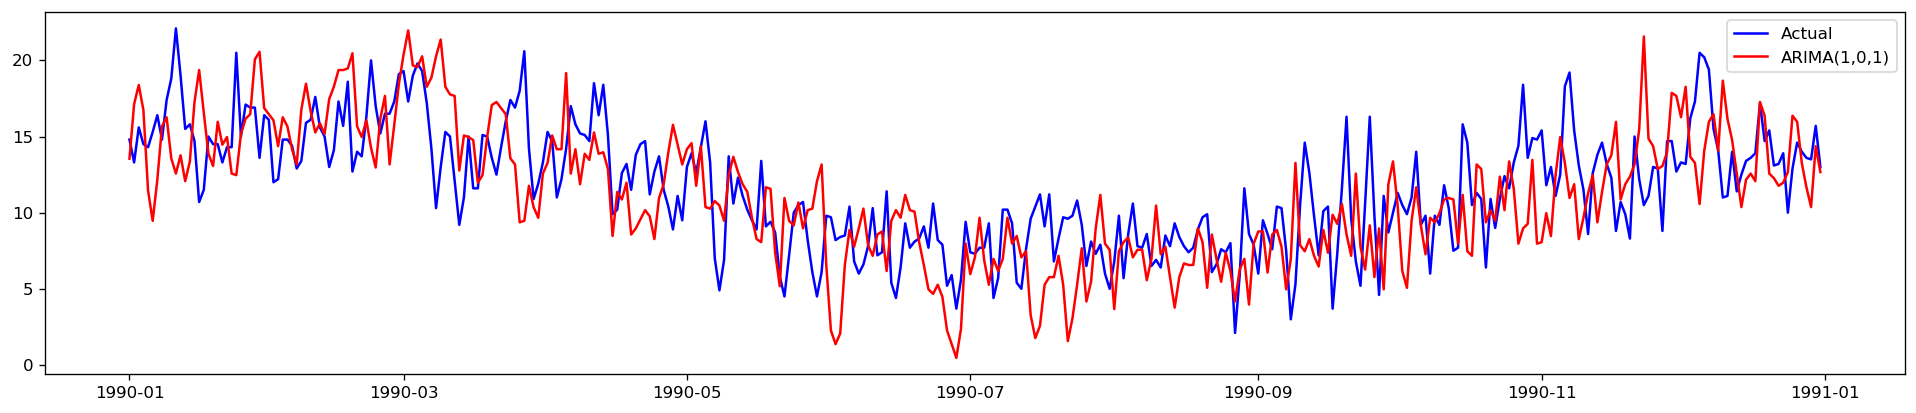

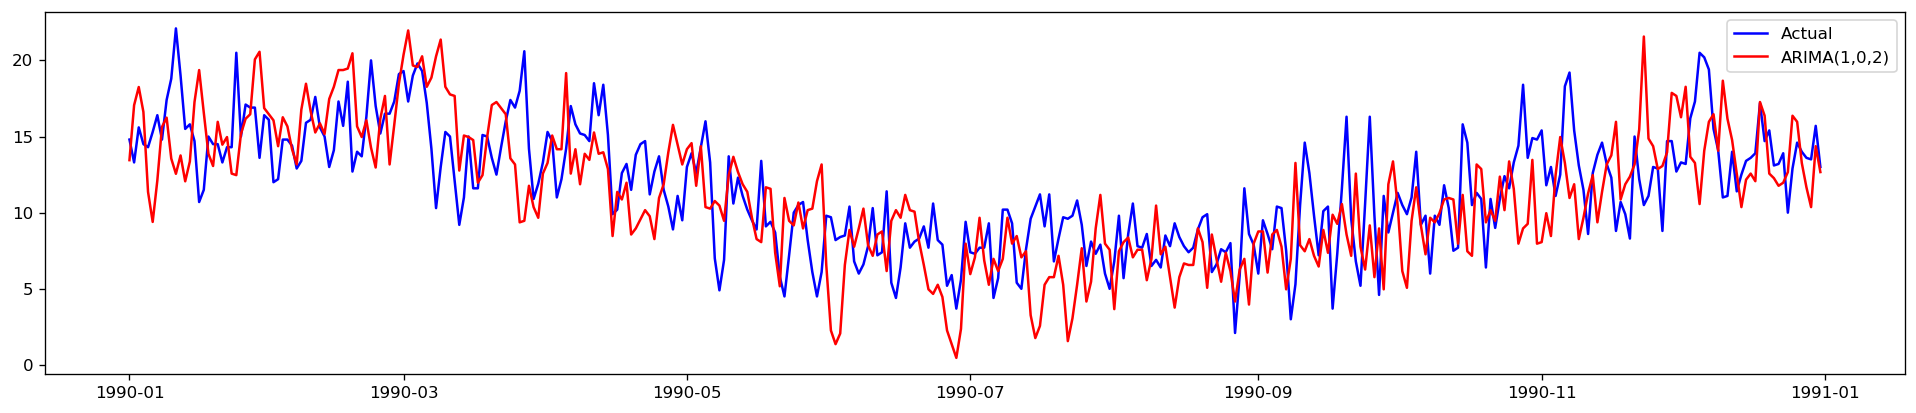

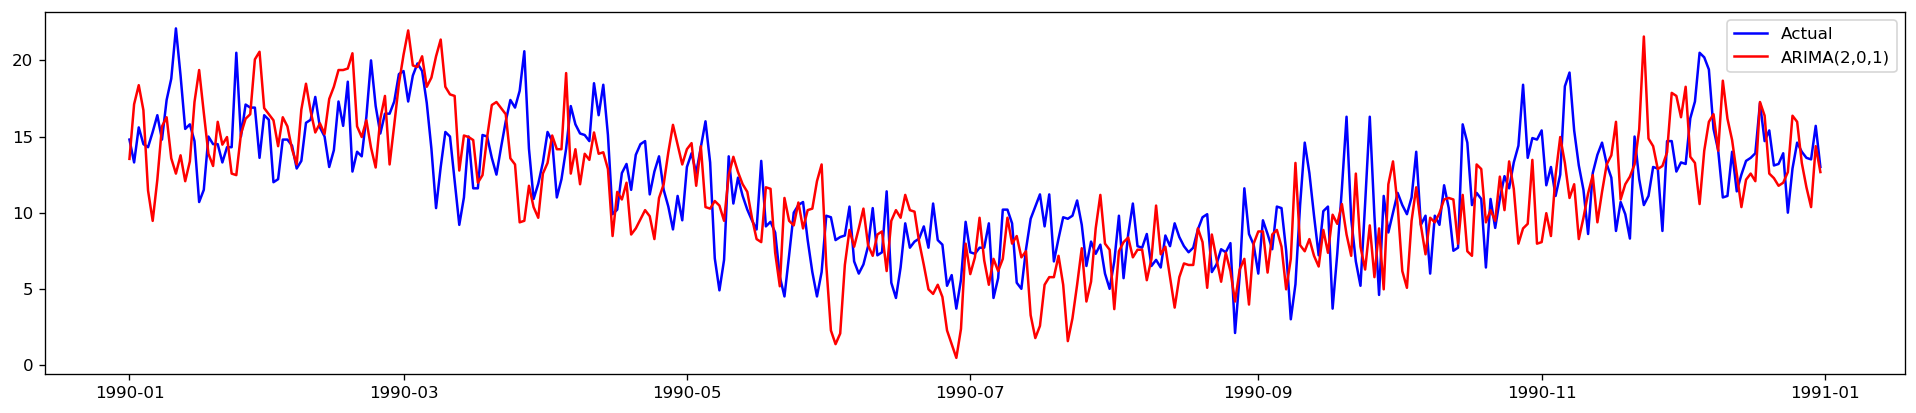

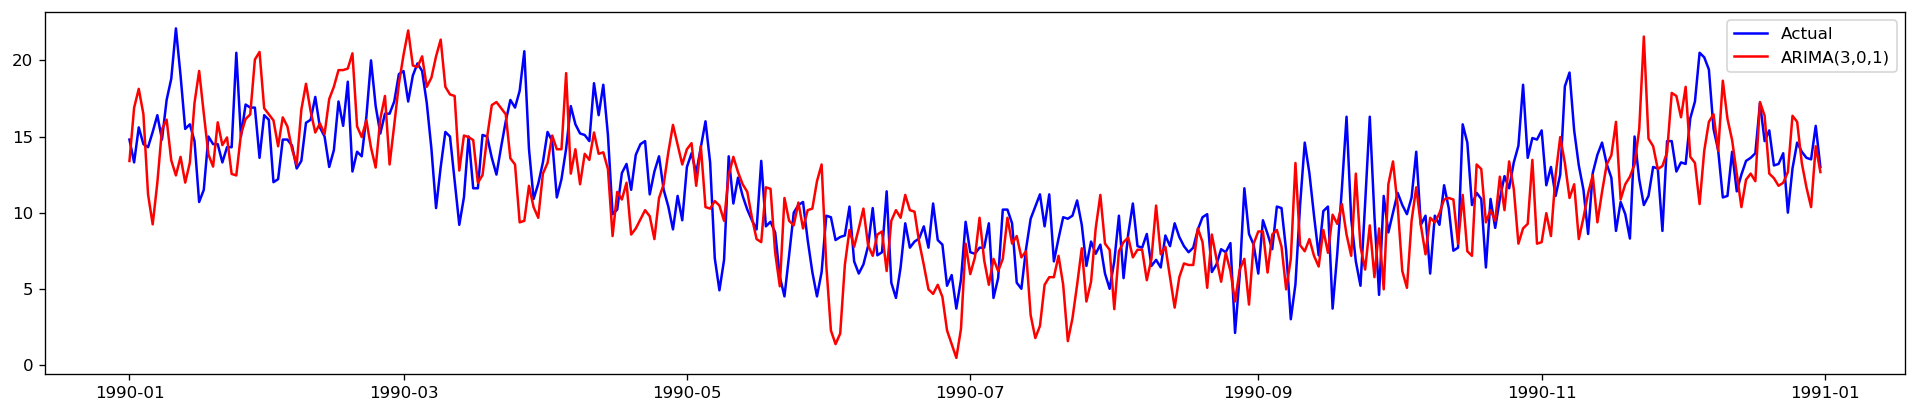

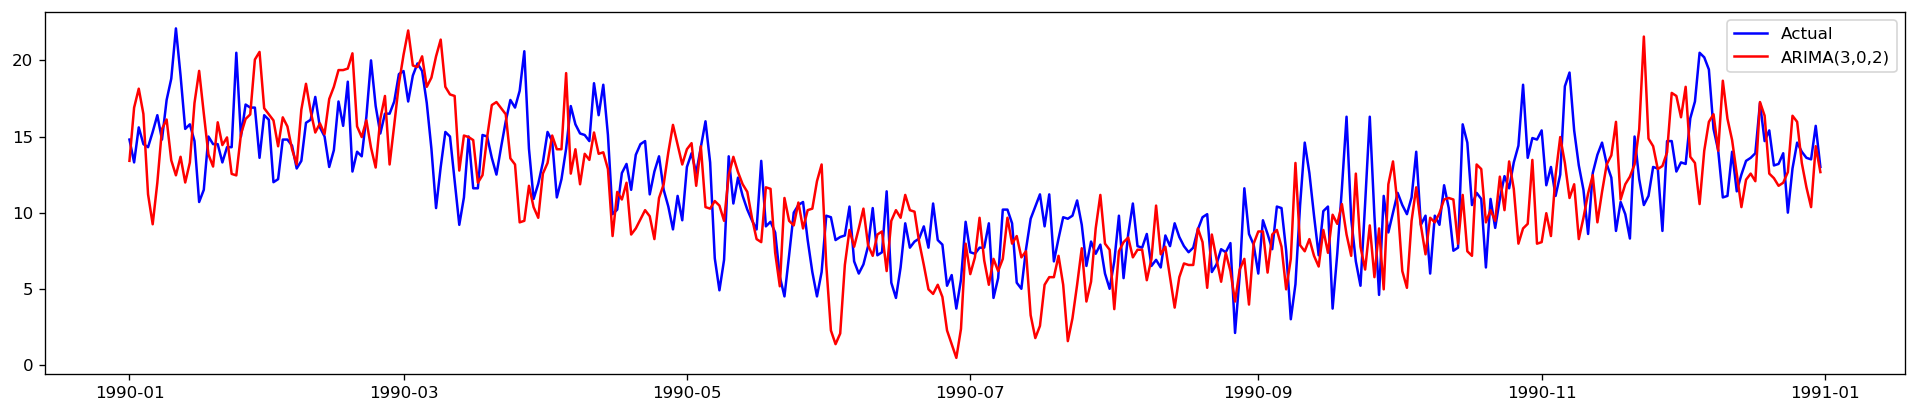

In [66]:
# Plot actual vs predicted
for k in gsa.model_dict.keys():
    plt.figure(figsize=(20,4))
    plt.plot(test['Date'], test['Temp'], 'b', label="Actual")
    loc="upper right"
    plt.plot(test['Date'], gsa.model_dict[k]['prediction'], 'r', label="ARIMA({})".format(k))
    plt.legend(loc="upper right")
    plt.savefig('ARIMA({})_predict_vs_actual.png'.format(k))
    plt.show()
    

# Data Preparation for Supervised ML

In [74]:
# lag_dataset_creator class
class lag_dataset_creator(object):
    def __init__(self,ori_list,lag_list,date_list):
        self.ori_list = ori_list
        self.lag_list = lag_list
        self.date_list = date_list
        self.list_dict = {}
    
    def create_df(self):
        self.list_dict['Date']=self.date_list
        
        for i in self.lag_list:
            lag = i
            list1 = []
            counter = 0
            while counter  < lag:
                list1.append(None)
                counter = counter + 1
            list1 = (list1 + self.ori_list)[:len(self.ori_list)]
            
            list_name = "Lag_{}".format(i)
            self.list_dict[list_name] = list1
            
        self.list_dict['Temp']=self.ori_list
        return pd.DataFrame.from_dict(self.list_dict).dropna(axis=0, how='any')
    
    

In [75]:
# Instantiate a lag_dataset_creator object and run
lag_list = [1,2,3,4,5,6,7,365,2*365,3*365]
obj = lag_dataset_creator(df['Temp'].tolist(),lag_list,df['Date'].tolist())
df_ml = obj.create_df()
df_ml

,Date,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_365,Lag_730,Lag_1095,Temp
1095,1984-01-01,18.0,20.4,16.1,11.1,13.9,15.0,17.5,18.4,17.0,20.7,19.5
1096,1984-01-02,19.5,18.0,20.4,16.1,11.1,13.9,15.0,15.0,15.0,17.9,17.1
1097,1984-01-03,17.1,19.5,18.0,20.4,16.1,11.1,13.9,10.9,13.5,18.8,17.1
1098,1984-01-04,17.1,17.1,19.5,18.0,20.4,16.1,11.1,11.4,15.2,14.6,12.0
1099,1984-01-05,12.0,17.1,17.1,19.5,18.0,20.4,16.1,14.8,13.0,15.8,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3645,1990-12-27,14.6,12.9,10.0,13.9,13.2,13.1,15.4,13.3,9.5,16.2,14.0
3646,1990-12-28,14.0,14.6,12.9,10.0,13.9,13.2,13.1,11.7,12.9,14.2,13.6
3647,1990-12-29,13.6,14.0,14.6,12.9,10.0,13.9,13.2,10.4,12.9,14.3,13.5
3648,1990-12-30,13.5,13.6,14.0,14.6,12.9,10.0,13.9,14.4,14.8,13.3,15.7


In [76]:
# Split data into train and test set
ml_train = df_ml.loc[df['Date'] < '1990-01-01']
ml_test = df_ml.loc[df['Date'] >= '1990-01-01']

X_train = ml_train.iloc[:,1:-1]
y_train = ml_train.iloc[:,-1:]

X_test = ml_test.iloc[:,1:-1]
y_test = ml_test.iloc[:,-1:]

# Random Forest Regression

In [77]:
# Instantiate RandomForestRegressor object
regr = RandomForestRegressor(n_estimators=20, random_state=0, criterion='mae')

# Fit regressor object with training set
regr.fit(X_train, y_train)

# Make prediction using regressor model
regr_prediction = regr.predict(X_test).tolist()

In [78]:
# Check model performance
print("MAE: {:.2f}".format(mean_absolute_error(y_test['Temp'].tolist(), regr_prediction)))
print("MRE: {:.2f}".format(mean_relative_error(regr_prediction, y_test['Temp'].tolist())))

MAE: 1.83
MRE: 0.19


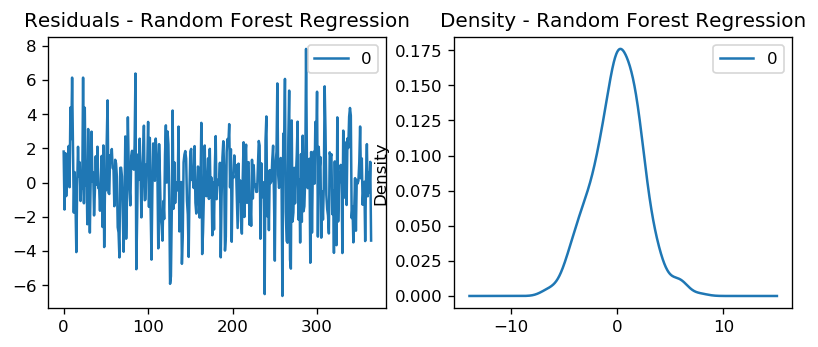

In [86]:
# Plot residual errors of model
rf_res = map(sub, y_test['Temp'].tolist(), regr_prediction)
residuals = pd.DataFrame(rf_res)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals - Random Forest Regression", ax=ax[0])
residuals.plot(kind='kde', title="Density - Random Forest Regression", ax=ax[1])
plt.savefig('RF_Residuals.png')
plt.show()

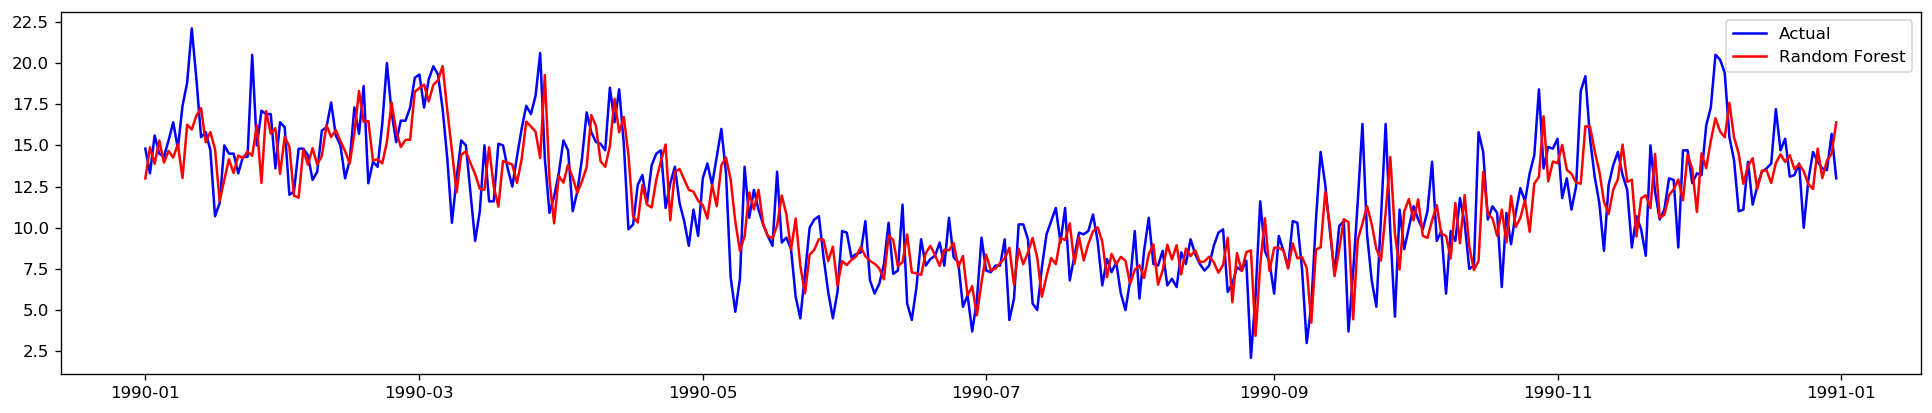

In [80]:
# Plot actual vs predicted
plt.figure(figsize=(20,4))
plt.plot(ml_test['Date'], ml_test['Temp'], 'b', label="Actual")
loc="upper right"
plt.plot(ml_test['Date'], regr_prediction, 'r', label="Random Forest") 
plt.legend(loc="upper right")
plt.savefig('RF_predict_vs_actual.png')
plt.show()

# Support Vector Regression

In [82]:
# Instantiate Support Vector Regressor object
clf = SVR(C=1.0, epsilon=0.3)

# Fit regressor object with training set
clf.fit(X_train, y_train)

# Make prediction using regressor model
clf_prediction = clf.predict(X_test).tolist()

In [83]:
# Check model performance
print("MAE: {:.2f}".format(mean_absolute_error(y_test['Temp'].tolist(), clf_prediction)))
print("MRE: {:.2f}".format(mean_relative_error(clf_prediction, y_test['Temp'].tolist())))

MAE: 1.75
MRE: 0.18


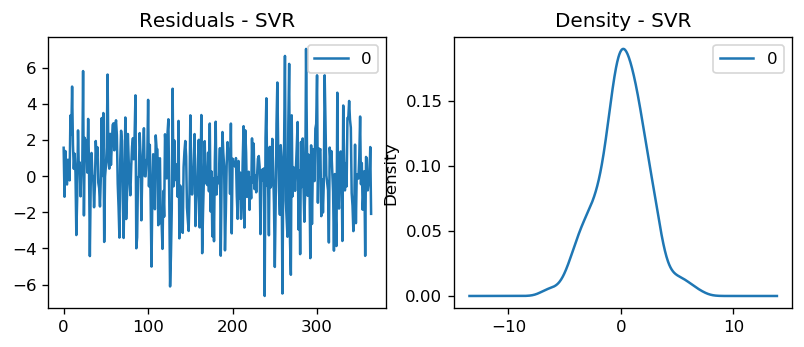

In [87]:
# Plot residual errors of model
clf_res = map(sub, y_test['Temp'].tolist(), clf_prediction)
residuals = pd.DataFrame(clf_res)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals - SVR", ax=ax[0])
residuals.plot(kind='kde', title="Density - SVR", ax=ax[1])
plt.savefig('SVR_Residuals.png')
plt.show()

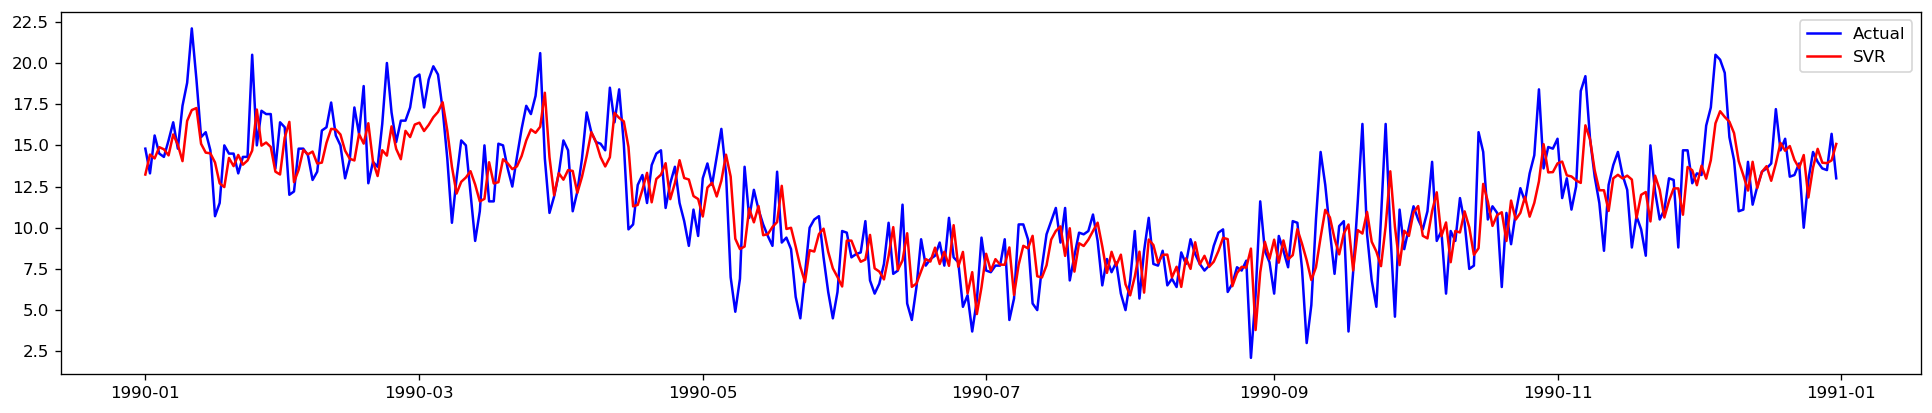

In [85]:
# Plot actual vs predicted
plt.figure(figsize=(20,4))
plt.plot(ml_test['Date'], ml_test['Temp'], 'b', label="Actual")
loc="upper right"
plt.plot(ml_test['Date'], clf_prediction, 'r', label="SVR")  
plt.legend(loc="upper right")
plt.savefig('SVR_predict_vs_actual.png')
plt.show()

# END

In [57]:
#2,0,1	15539	15569	2.87	0.28
model = ARIMA(train_differenced.tolist(), order=(2,0,1))
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(steps=365)[0]
history1 = train['Temp'].tolist()
predicted = []
day = 1
for yhat in forecast:
    inverted = inverse_difference(history1, yhat, day_in_year)
    print('Day %d: %f' % (day, inverted))
    history1.append(inverted)
    predicted.append(inverted)
    day += 1


Day 1: 13.533048
Day 2: 17.121088
Day 3: 18.370979
Day 4: 16.731384
Day 5: 11.453437
Day 6: 9.461767
Day 7: 12.164875
Day 8: 15.666041
Day 9: 16.266477
Day 10: 13.566640
Day 11: 12.566701
Day 12: 13.766724
Day 13: 12.066732
Day 14: 13.366736
Day 15: 17.266737
Day 16: 19.366737
Day 17: 16.566737
Day 18: 13.866737
Day 19: 13.066737
Day 20: 15.966738
Day 21: 14.466738
Day 22: 14.966738
Day 23: 12.566738
Day 24: 12.466738
Day 25: 15.166738
Day 26: 16.166738
Day 27: 16.466738
Day 28: 20.066738
Day 29: 20.566738
Day 30: 16.866738
Day 31: 16.466738
Day 32: 16.066738
Day 33: 14.366738
Day 34: 16.266738
Day 35: 15.666738
Day 36: 14.166738
Day 37: 13.166738
Day 38: 16.766738
Day 39: 18.466738
Day 40: 16.666738
Day 41: 15.266738
Day 42: 15.866738
Day 43: 15.166738
Day 44: 17.466738
Day 45: 18.266738
Day 46: 19.366738
Day 47: 19.366738
Day 48: 19.466738
Day 49: 20.466738
Day 50: 15.666738
Day 51: 14.966738
Day 52: 16.066738
Day 53: 14.266738
Day 54: 12.966738
Day 55: 16.166738
Day 56: 17.666738
Da

In [58]:
print(model_fit.aic)
print(model_fit.bic)
error = mean_absolute_error(test['Temp'], predicted)
print(error)

15538.825326046332
15568.722020522644
2.871801343525795


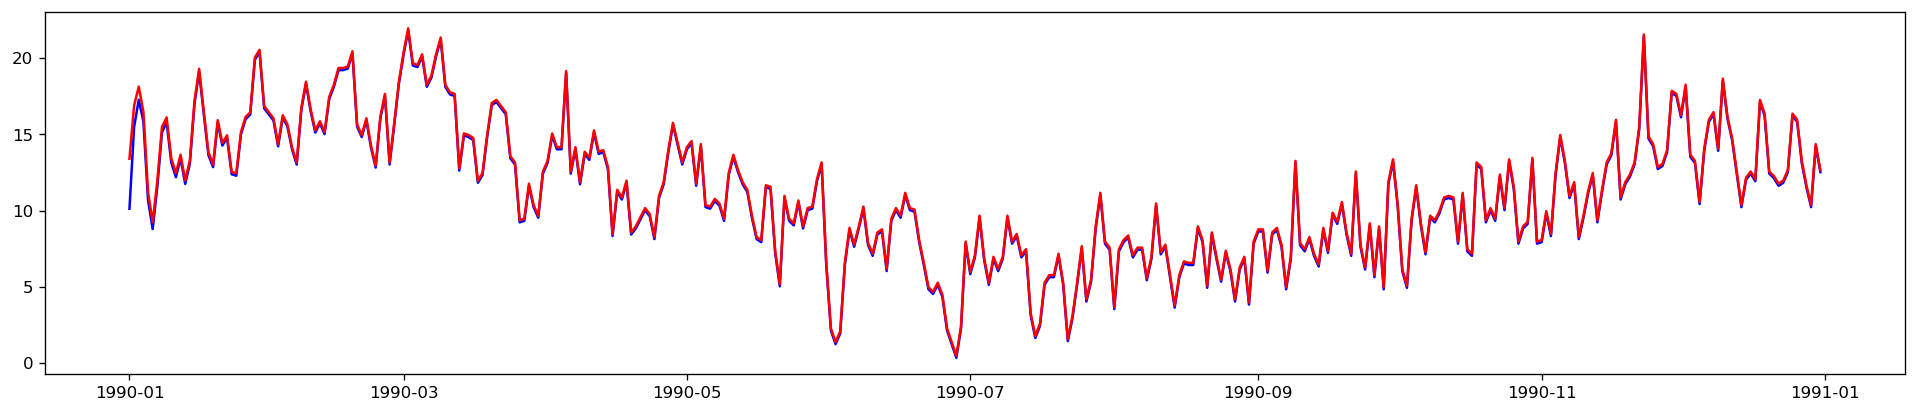

In [230]:
plt.figure(figsize=(20,4))
plt.plot(test['Date'], gsa.model_dict['3,0,2']['prediction'], 'b') # plotting t, a separately 
plt.plot(test['Date'], predicted, 'r') # plotting t, b separately 
# plt.plot(train['Date'], rolstd, 'g') # plotting t, c separately 

In [236]:
gsa.model_dict['3,0,2']['prediction'][:5]

[10.1209568564235,
 15.481207542528345,
 17.276459589822185,
 15.841696542528695,
 10.679878212088996]

In [237]:
predicted[:5]

[13.403012949209486,
 16.895228554747742,
 18.140340871709004,
 16.482331499303843,
 11.20787558753073]